In this notebook, we will 
- Make a linear Regression (LR) with 59 Rdkit descriptors
- Use the p-value test to select the important features using the LR
- Use the Lasso Regression to find significant features
- Predict the ERed of molecules in the test dataset
- save the model as a pickle file

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# import custom functions from the python file
import sys
sys.path.append('../') # path of the directory that contains Chemfunctions.py
import Chemfunctions as chemfun


# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# RDKit 
import rdkit.Chem as Chem

Get train and test data from the Data directory
- train and test data features are already scaled using 0_Features_split.ipynb

In [2]:
X_train = pd.read_csv(r'./Data/X_train_70pc_scaled.csv')
X_test = pd.read_csv(r'./Data/X_test_30pc_scaled.csv')
y_train = pd.read_csv(r'./Data/y_train_70pc_target.csv')
y_test = pd.read_csv(r'./Data/y_test_30pc_target.csv')

print(f'X_train.shape={X_train.shape}, y_train.shape={y_train.shape}')
print(f'X_test.shape={X_test.shape}, y_test.shape={y_test.shape}')

X_train.shape=(3809, 59), y_train.shape=(3809, 1)
X_test.shape=(1633, 59), y_test.shape=(1633, 1)


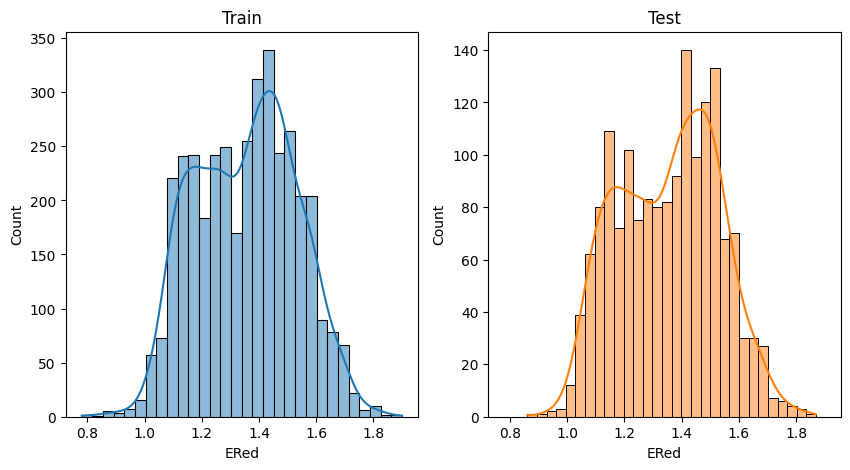

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
sns.histplot(ax=axs[0],x=y_train["ERed"], bins=30, kde=True,color="tab:blue")
sns.histplot(ax=axs[1],x=y_test["ERed"], bins=30, kde=True,color="tab:orange")
axs[0].set_xlabel("ERed")
axs[1].set_xlabel("ERed")
axs[0].set_ylabel("Count")
axs[1].set_ylabel("Count")
axs[0].set_title("Train")
axs[1].set_title("Test")
plt.show()

# Feature selection 

*We will use the p-values of individual regression coeff to select the imp features*

To get the overall F-statistic of the model and the p-values we require the model summary. Unfortunately, we don't get that from the sklearn model. So we will use statsmodels.

[Ref1: Implement OLS in sm](https://www.statology.org/sklearn-linear-regression-summary/)

[Ref2: How to interpret the linear regression p-values](https://www.statology.org/linear-regression-p-value/)

# 1. with sklearn

In [4]:
from sklearn.linear_model import LinearRegression


model=LinearRegression()

model.fit(X=X_train,y=y_train)

print(f"intercept = {model.intercept_[0]:0.2f}, \n model coeff. = \n {model.coef_}, \n R^2 = {model.score(X=X_train,y=y_train):0.2f}")

intercept = 1.35, 
 model coeff. = 
 [[ 4.35344933e-02 -6.69421461e-05  1.62085794e+02  1.68536998e-02
   1.05272031e-02 -6.04536999e-03  1.77585134e-02 -7.63939351e+10
  -1.08754793e+11 -1.10769417e+11 -4.88632220e+10 -2.64575843e+10
  -1.89263857e+10 -2.66367076e+10 -2.47166163e+10 -1.50515695e+11
  -2.40612067e+11 -1.83574921e+11 -1.34547327e+11  9.75798235e+10
   1.15881838e+11  1.75811782e+10  4.38722937e+10  2.74057953e+11
   2.72769944e+11  8.43592194e+10  1.05312011e+11  2.51186880e+00
   5.80991190e-01  1.91971337e-01 -7.82915238e+00  1.58892575e+02
  -2.51690335e-03  2.03247070e-02  8.68377686e-02  8.52050781e-02
   1.05041504e-01  3.05175781e-02  3.73535156e-02  7.66906738e-02
  -1.66866302e-01  2.08961487e-01  5.56945801e-03 -4.53338623e-02
   6.51931763e-02  4.12933350e-01  2.78747559e-01 -1.21861542e+02
   7.26323097e+11  4.33355614e+11 -6.20042457e+11 -1.16424561e-02
   4.52928925e+00 -6.55272064e+01  1.50756836e-02  2.89916992e-04
   3.80586982e-02 -1.86233521e-02 -3.47

In [5]:
import statsmodels.api as sm

#define response variable
y=y_train

#define predictor variables
x=X_train

#add constant to predictor variables
x=sm.add_constant(x)

model=sm.OLS(y,x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   ERed   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     260.8
Date:                Fri, 18 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:08:49   Log-Likelihood:                 4251.7
No. Observations:                3809   AIC:                            -8387.
Df Residuals:                    3751   BIC:                            -8025.
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

**With statsmodel we get detailed summary. we will use the P>|t| values for feature selection**

# Feature Selection based on the p-values
## if X is a feature and Y is the target . then Y=beta*X+c
## H0 (null hypothesis): feature is not linearly related to the target variable or beta=0
## H1 (alternative hypothesis): feature is linearly related to the target variable or beta!=0

- *After implementing the linear regression with all features, if we find that the p-value of any feature is smaller than the alpha = 0.05 (95% confidence interval) or p < 0.05, then it suggests that there is a strong statistical evidence to reject the H0, in other words, we don't have sufficent evidence to claim that beta=0, hence we can assume that beta!=0 at 95% CI* 


[Interpretation of the p-value test in linear regression](https://medium.com/nerd-for-tech/hypothesis-testing-on-linear-regression-c2a1799ba964)

In [6]:
alpha = 0.05  

features=X_train.columns

print(f'initial number of features = {len(features)}')

y=y_train

for iter in np.arange(5):
    
    x=X_train.loc[:,features]
    x=sm.add_constant(x)

    model=sm.OLS(y,x).fit()
    
    p_values = model.summary2().tables[1]['P>|t|'][1:] < alpha # 0 the element is for the constant 
    
    # remove columns with p-values > 0.05
    features=features[p_values]
    print(f'iter = {iter}, number of features left = {len(features)}')

print(f'features left = {features.values}')


initial number of features = 59
iter = 0, number of features left = 49
iter = 1, number of features left = 48
iter = 2, number of features left = 48
iter = 3, number of features left = 48
iter = 4, number of features left = 48
features left = ['MaxEStateIndex' 'MolWt' 'BCUT2D_MRLOW' 'Ipc' 'PEOE_VSA1' 'PEOE_VSA10'
 'PEOE_VSA11' 'PEOE_VSA12' 'PEOE_VSA13' 'PEOE_VSA14' 'PEOE_VSA2'
 'PEOE_VSA3' 'PEOE_VSA6' 'PEOE_VSA7' 'PEOE_VSA8' 'PEOE_VSA9' 'SMR_VSA1'
 'SMR_VSA10' 'SMR_VSA3' 'SMR_VSA4' 'SMR_VSA5' 'SMR_VSA6' 'SMR_VSA7'
 'SMR_VSA9' 'SlogP_VSA2' 'SlogP_VSA3' 'SlogP_VSA4' 'SlogP_VSA6' 'TPSA'
 'EState_VSA3' 'EState_VSA4' 'EState_VSA5' 'EState_VSA6' 'VSA_EState2'
 'VSA_EState3' 'VSA_EState5' 'VSA_EState7' 'VSA_EState8' 'VSA_EState9'
 'NHOHCount' 'NumAliphaticCarbocycles' 'NumAliphaticRings' 'MolLogP'
 'fr_NH0' 'fr_Ndealkylation1' 'fr_bicyclic' 'fr_methoxy'
 'fr_unbrch_alkane']


Based on the p-test values we can drop 11 out of the 59 features 

# Linear Model

Let's compare the performance of the linear regression model with all 59 and 48 selected features

In [7]:
# # To import the updated functions from the chemfun use following lines of code
# import importlib
# importlib.reload(chemfun)

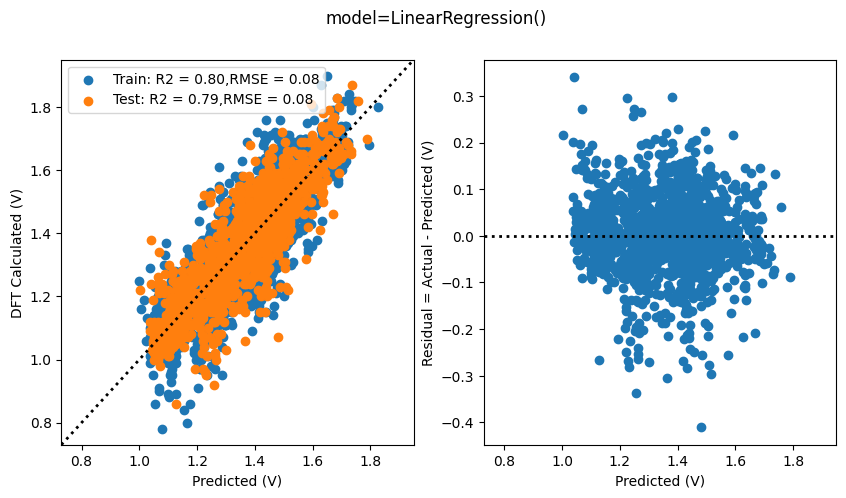

In [8]:
from sklearn.linear_model import LinearRegression

chemfun.pairity_plot(model=LinearRegression(),X_train=X_train,X_test=X_test,y_train=y_train["ERed"],y_test=y_test["ERed"])

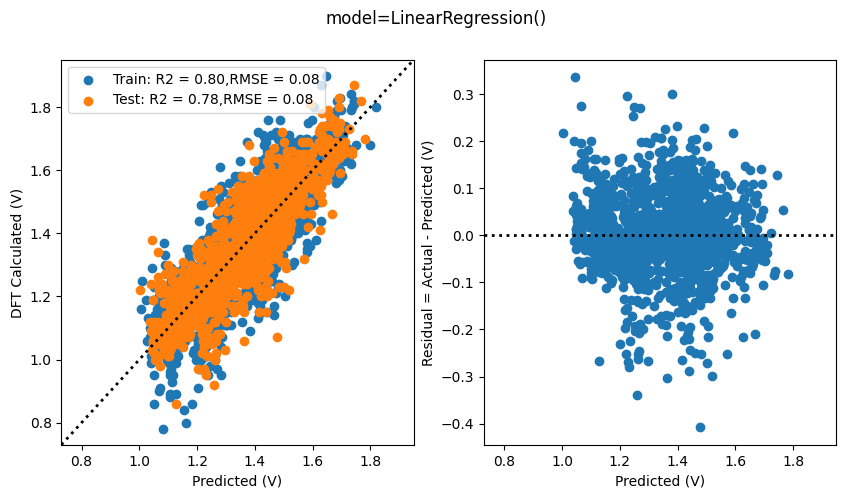

In [9]:
chemfun.pairity_plot(model=LinearRegression(),X_train=X_train.loc[:,features],X_test=X_test.loc[:,features],y_train=y_train["ERed"],y_test=y_test["ERed"])

- Can use 48 features instead of 59 without loosing the prediction accuracy
- Errors/Residuals are randomly distributed: Homodescacity assumption is valid here

# Let's try the sklearn implementation of the Recursive Feature Elimination method with the Linear regression model

In [10]:
# from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, RFECV
rfe = RFECV(estimator=LinearRegression(), cv=5, step=1,min_features_to_select=10)

rfe.fit(X_train, y_train)
print(f"features selected with the RFECV using the linear regression")
rfe.feature_names_in_[rfe.support_]

features selected with the RFECV using the linear regression


array(['PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA13', 'PEOE_VSA3', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8',
       'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6',
       'SMR_VSA7', 'SMR_VSA9', 'NumAliphaticCarbocycles',
       'NumAliphaticHeterocycles', 'NumAliphaticRings'], dtype=object)

In [11]:
len(rfe.feature_names_in_[rfe.support_])

19

Predictions with the RFE selected features

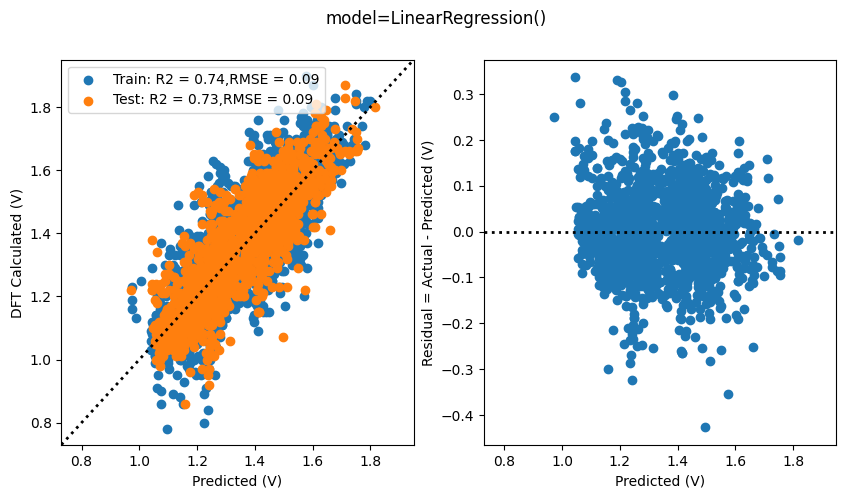

In [12]:
features=rfe.feature_names_in_[rfe.support_]
chemfun.pairity_plot(model=LinearRegression(),X_train=X_train.loc[:,features],X_test=X_test.loc[:,features],y_train=y_train["ERed"],y_test=y_test["ERed"])

- The model accuracy on the test and train data decreased when we used 19 RFE selected features 
- Need to increase the number of features, let's select more features with RFE

1. minimum 30 features

features selected with the RFECV using the linear regression
54


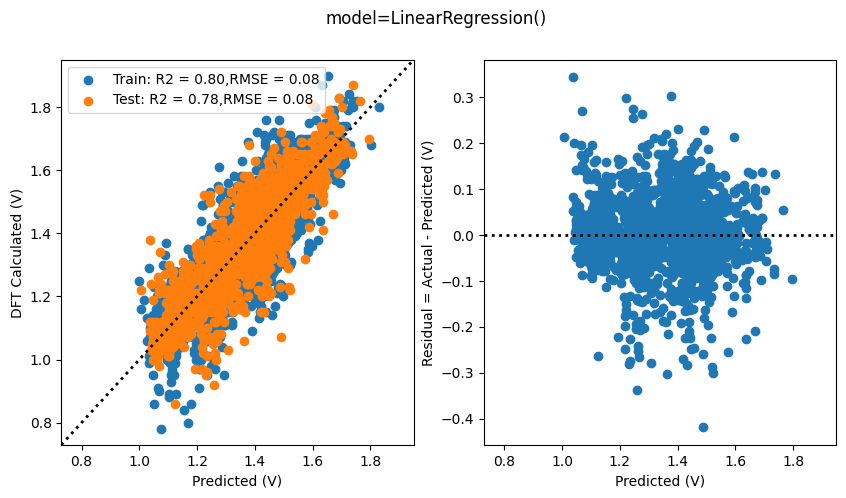

In [13]:
from sklearn.feature_selection import RFE, RFECV
rfe = RFECV(estimator=LinearRegression(), cv=5, step=1,min_features_to_select=30)

rfe.fit(X_train, y_train)
print(f"features selected with the RFECV using the linear regression")
# rfe.feature_names_in_[rfe.support_]

features=rfe.feature_names_in_[rfe.support_]
print(len(features))
chemfun.pairity_plot(model=LinearRegression(),X_train=X_train.loc[:,features],X_test=X_test.loc[:,features],y_train=y_train["ERed"],y_test=y_test["ERed"])

with 54 feature performance improved

# Use LASSO and see the feature selection

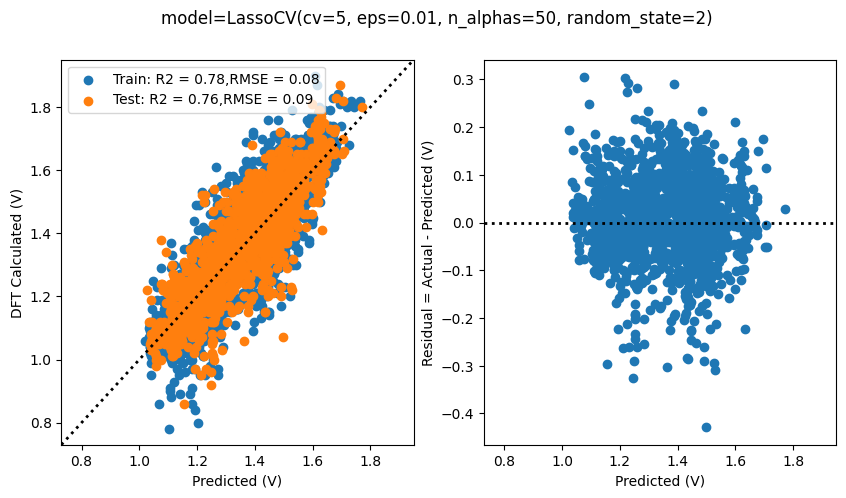

In [14]:
from sklearn.linear_model import LassoCV


chemfun.pairity_plot(model=LassoCV(eps=0.01,n_alphas=50,cv=5,random_state=2),X_train=X_train,X_test=X_test,y_train=y_train["ERed"],y_test=y_test["ERed"])

let's look at the lasso selected features

In [15]:
model4=LassoCV(eps=0.01,n_alphas=50,cv=5,random_state=2)
model4.fit(X_train,y_train["ERed"])
len(model4.feature_names_in_[model4.coef_!=0])

32

In [16]:
model4.feature_names_in_[model4.coef_!=0]

array(['MinEStateIndex', 'Chi3n', 'Ipc', 'PEOE_VSA1', 'PEOE_VSA11',
       'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA6',
       'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA3', 'SMR_VSA5',
       'SMR_VSA9', 'SlogP_VSA2', 'SlogP_VSA6', 'EState_VSA3',
       'EState_VSA8', 'VSA_EState2', 'VSA_EState3', 'VSA_EState8',
       'VSA_EState9', 'NumAliphaticHeterocycles', 'NumAliphaticRings',
       'NumRotatableBonds', 'fr_NH0', 'fr_Ndealkylation1',
       'fr_aryl_methyl', 'fr_bicyclic', 'fr_methoxy'], dtype=object)

Lasso selected 32 features from the set of 58 features

# Save model with the pickle 

we will save the LR model with 59 features and compare it's performance with other models such as SVR, GBR, and NN

In [17]:
import pickle
model=LinearRegression().fit(X_train,y_train)
pickle.dump(model, open(r'./Models/LinearRegression.sav', 'wb'))

Load model with pickle

In [18]:
LR_model = pickle.load(open(r'./Models/LinearRegression.sav', 'rb'))
# LR_model

In [19]:
# if both models are same then we will get true
(LR_model.coef_==model.coef_).all(), (LR_model.intercept_==model.intercept_).all()

(True, True)